This notebook exists to investigate the need of the parameters included in the dataset. Each parameter is tested against the others to see if they are statistically correlated....
Then wrapper methods are used to determine which ones are most important....
Want to reduce number of parameters needed to produce a good output so to reduce the chance of overfitting and increase the generalisation of the model.

In [3]:
%run "Parameter_Estimation.ipynb" #allowing access to parameters

  0%|                                                                                          | 0/549 [00:00<?, ?it/s]

Filtering Database


100%|████████████████████████████████████████████████████████████████████████████████| 549/549 [01:23<00:00,  6.59it/s]


221 remaining out of 290


  8%|██████▌                                                                         | 18/221 [00:00<00:01, 175.57it/s]

normalising and preproccessing signals using DWT


100%|███████████████████████████████████████████████████████████████████████████████| 221/221 [00:01<00:00, 198.40it/s]


6
Calculating Time Domain Features
Calculating Frequency Domain Features
Calculating Non-Linear Domain Features


In [4]:
from scipy.stats import pearsonr #for comparisson of correlations
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, mutual_info_classif #for forward feature selection
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [5]:
def get_balanced_accuracy(y_test, y_pred):
    """
    balanced accuracy....
    """
    num_healthy_true = np.sum([x=='Healthy' for x in y_test])
    num_unhealthy_true = len(y_test) - num_healthy_true
    count_healthy_accurate = 0
    count_unhealthy_accurate = 0
    for i in range(0, len(y_test)):
        if y_pred[i] == y_test[i] == 'Unhealthy':
            count_unhealthy_accurate +=1
        elif y_pred[i] == y_test[i] == 'Healthy':
            count_healthy_accurate +=1
    healthy_percentage = count_healthy_accurate/num_healthy_true
    unhealthy_percentage = count_unhealthy_accurate/num_unhealthy_true
    balanced_accuracy = (healthy_percentage + unhealthy_percentage) * 0.5
    return balanced_accuracy

def get_specificity(y_test, y_pred):
    """
    true negative rate
    """
    true_negative = 0
    false_positive = 0
    for i in range(0, len(y_test)):
        if y_pred[i] == y_test[i] == 'Healthy':
            true_negative += 1
        elif y_pred[i] != y_test[i] and y_test[i] == 'Healthy':
            false_positive += 1
    
    return true_negative / (true_negative+false_positive)
            
def get_f1_score(y_test, y_pred):
    """
    balance between precision and recall
    """
    true_positive = 0
    false_positive = 0
    false_negative = 0
    for i in range(0, len(y_test)):
        if y_pred[i] == y_test[i] == 'Unhealthy':
            true_positive += 1
        elif y_pred[i] != y_test[i] and y_test[i] == 'Healthy':
            false_positive += 1
        elif y_pred[i] != y_test[i] and y_test[i] == 'Unhealthy':
            false_negative += 1
    return (2*true_positive)/(2*true_positive+false_positive+false_negative)

def scoring_function(model, X, y):
    """
    change to incorporate balanced accuracy 
    """
    
    y_pred = model.predict(X)
    y_test = y
    balanced_acc = get_balanced_accuracy(y_test, y_pred)
    #specificity = get_specificity(y_test, y_pred)
    f1 = get_f1_score(y_test, y_pred)
    
    
    return f1*0.7 + balanced_acc*0.3

def convert_multi_dict_to_array(params, nan_indices):
    no_features = len(params)
    params_list = []
    for j in range(0, no_channels):
        params_array = np.zeros(shape=(len(health_state[nan_indices[j]]), no_features))
        for i, values in enumerate(params.values()):
            params_array[:, i] = values[j]
        params_list.append(params_array)
    return params_list, no_features

def convert_single_dict_to_array(params, nan_indices):
    no_features = len(params)
    params_array = np.zeros((len(health_state[nan_indices]), no_features))
    for i, values in enumerate(params.values()):
        params_array[:, i] = values
    return params_array, no_features

def reduce_parameter_set(params, selected_indices, channel):
    select_params = {}
    for i, key in enumerate(params.keys()):
        if i in selected_indices:
            select_params[key] = params[key][channel]
    return select_params
        
def reduce_parameter_set_single(params, selected_indices):
    select_params = {}
    for i, key in enumerate(params.keys()):
        if i in selected_indices:
            select_params[key] = params[key]
    return select_params
    

First convert the parameters to an array for easy investigation.

In [6]:
#pre-calculation of relevant health array for every channel
nan_indices = []
health_state = allowed_patients.get_diagnoses()
for j in range(0, no_channels):
    signal_nan_indices = []
    for i, signal in enumerate(denoised_signals[:, j]):
        if np.isnan(signal).all():
            signal_nan_indices.append(False)
        else:
            signal_nan_indices.append(True)
    nan_indices.append(signal_nan_indices)
    
health_state = np.array(health_state)
nan_indices = np.array(nan_indices)

In [7]:
params_array, no_features = convert_multi_dict_to_array(params, nan_indices)

desired_no_feats = 4

In [9]:
print(f'Selecting the {desired_no_feats} most important features from {no_features} for each channel')

Selecting the 4 most important features from 18 for each channel


To select the most important features to be used in analysis used forward sfs

In [10]:
def forward_selection(params, health_state, scorer=scoring_function, k=6):
    
    X_train, X_test, y_train, y_test = train_test_split(params, health_state, test_size=0.3, stratify = health_state)

    #initialise svc
    svm = SVC(class_weight='balanced')

    SFS_forward = SequentialFeatureSelector(estimator=svm, scoring=scoring_function, cv=3, n_features_to_select=k)

    SFS_forward.fit(X_train, y_train)

    selected_indices = SFS_forward.get_support(indices=True)
    
    return selected_indices

Filter methods

In [11]:
def filter_method(params, health_state, k=6, scorer=mutual_info_classif):
    # Apply SelectKBest with mutual information
    selector = SelectKBest(score_func=scorer, k=k)
    
    
    X_new = selector.fit_transform(params, health_state)
    
    # Get the indices of selected features
    selected_indices = selector.get_support(indices=True)
    
    return selected_indices

Combining approaches

In [12]:
def run_feature_selection():
    selected_params = {}
    for i in range(0, no_channels):
        #find indices to keep through filter method

        chosen_indices_filt = filter_method(params_array[i], health_state[nan_indices[i]], k=8)#encoded health state?

        #reduce the parameter based on these indices
        reduced_params = reduce_parameter_set(params, chosen_indices_filt, i)

        #convert new params dict back into array
        reduced_params_array, no_features = convert_single_dict_to_array(reduced_params, nan_indices[i])

        #find 4 best features through sfs
        chosen_indices_filt_sfs = forward_selection(reduced_params_array, health_state[nan_indices[i]], scorer=scoring_function, k=desired_no_feats)

        selected_params[i] = reduce_parameter_set_single(reduced_params, chosen_indices_filt_sfs)
    return selected_params

In [13]:
selected_params = run_feature_selection()
for i in range(0, no_channels):
    print(f"Selected features for channel {i}:")
    print(list(selected_params[i].keys()))

Selected features for channel 0:
['rr_amps', 'mean', 'sd_ratio_outliers_removed', 'age']
Selected features for channel 1:
['rr_amps', 'lf', 'shannon_en', 'age']
Selected features for channel 2:
['rr_std', 'skews', 'kurtosis', 'age']
Selected features for channel 3:
['std', 'skews', 'lf', 'age']
Selected features for channel 4:
['rr_std', 'rr_amps', 'lf', 'age']
Selected features for channel 5:
['rr_std', 'mean', 'hf', 'age']


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]
<ipython-input-20-2190e21e02c8>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[channel].set_xticklabels(features.keys(), rotation=90)


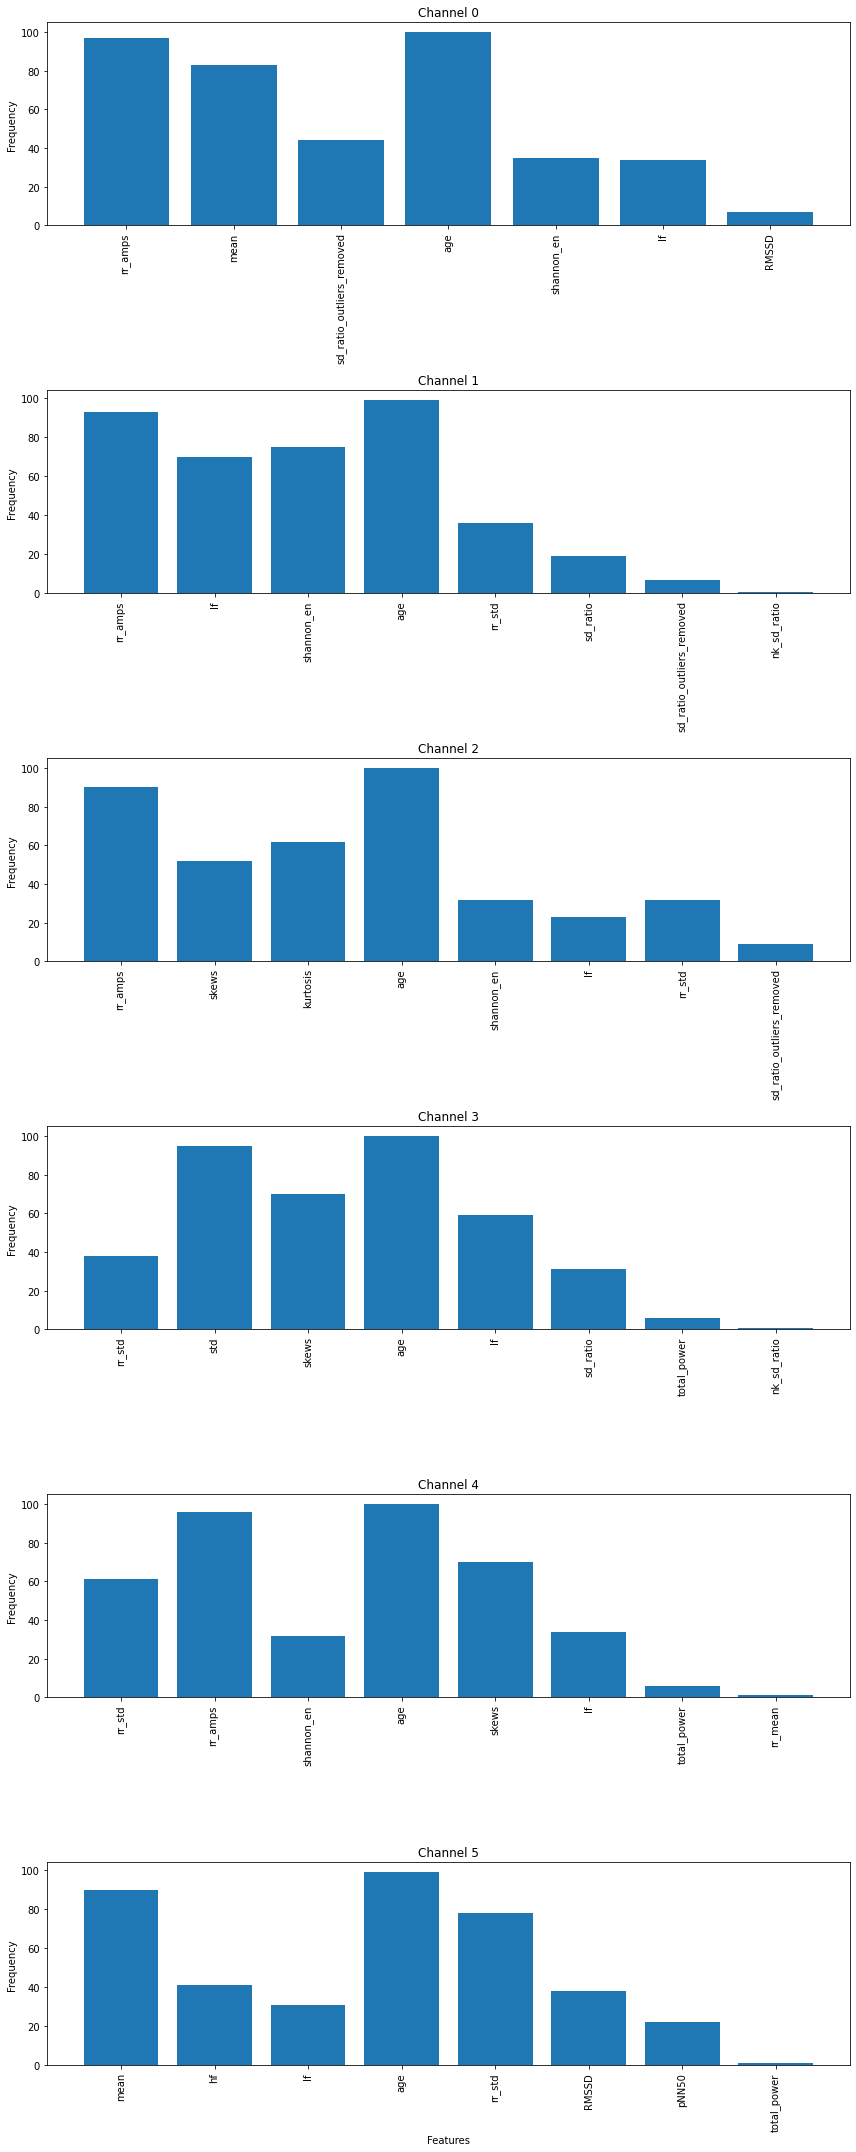

In [20]:
from collections import defaultdict, Counter

# initialize dict to count feature selections for each channel
feature_counts = defaultdict(Counter)

# select features 100 times and update the counts
for _ in tqdm(range(100)):
    selected_features = run_feature_selection()
    for i in range(0, 6):
        feature_counts[i].update(selected_features[i].keys())
                                 

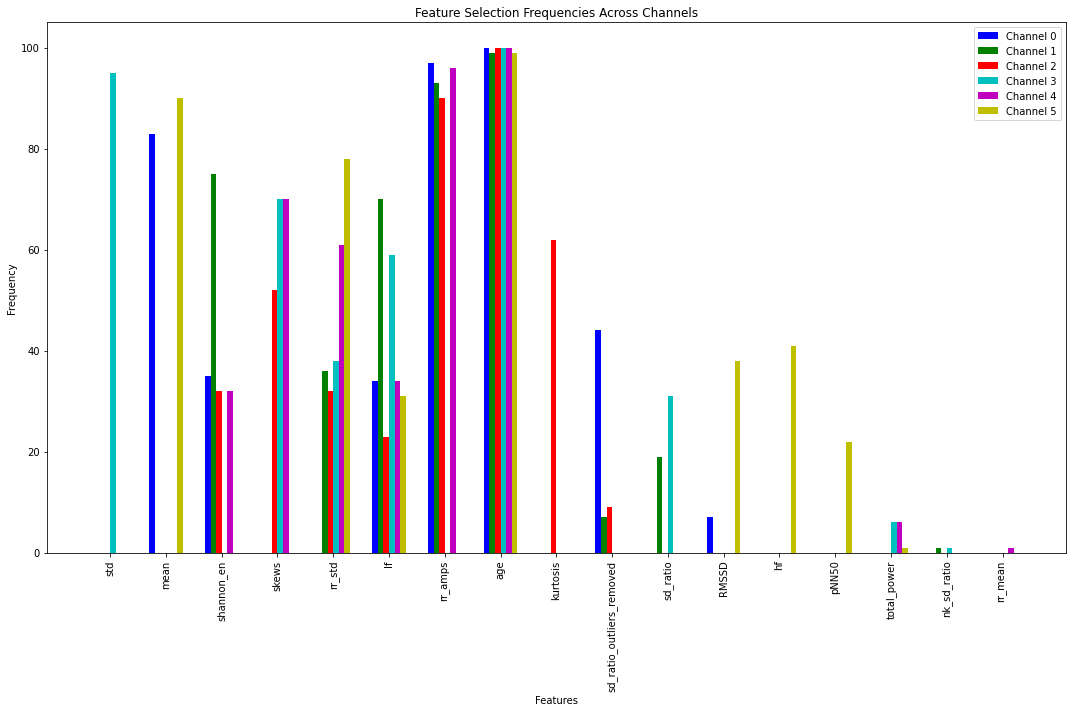

In [27]:

# Combine all features from all channels and calculate their total frequencies
total_feature_counts = Counter()
for features in feature_counts.values():
    total_feature_counts.update(features)

# Sort features by total frequency
sorted_features = [feature for feature, count in total_feature_counts.most_common()]

# Rearrange features to have the most common ones in the middle
middle_index = len(sorted_features) // 2
sorted_features = sorted_features[:middle_index][::-1] + sorted_features[middle_index:]

# Plotting the results
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.1  # Width of the bars
indices = list(range(len(sorted_features)))

# Colors for each channel
colors = ['b', 'g', 'r', 'c', 'm', 'y']

for channel in range(6):
    counts = [feature_counts[channel][feature] for feature in sorted_features]
    bar_positions = [i + channel * bar_width for i in indices]
    ax.bar(bar_positions, counts, bar_width, label=f'Channel {channel}', color=colors[channel])

# Adding x-ticks
ax.set_xticks([i + bar_width * 2.5 for i in indices])
ax.set_xticklabels(sorted_features, rotation=90)

# Labels and Title
ax.set_xlabel('Features')
ax.set_ylabel('Frequency')
ax.set_title('Feature Selection Frequencies Across Channels')
ax.legend()

plt.tight_layout()
plt.savefig('feature_selection_frequencies_combined.png', bbox_inches='tight')
plt.show()